In [146]:
import tensorflow as tf

In [147]:
import pandas as pd
import os
import numpy as np
from keras_preprocessing import image as im
tf.random.set_seed(
    5
)

# Loading data

In [148]:
def load_data(image_path, annotations_path):
    df = pd.read_csv(annotations_path)
    df = df[~df['human_sentiment'].isna()]
    in_folder = os.listdir(image_path)
    df.loc[df['image_name'].isin(in_folder), 'image_name'] = \
    df.loc[df['image_name'].isin(in_folder), 'image_name'].apply(lambda x: os.path.join(image_path,x))
    images = []
    for image_name in df['image_name'].values:
        images.append(np.array(im.load_img(image_name, target_size=(224,224))))
    images = np.array(images)
    images = images/255
    annotations = df['annotation'].str.lower().values
    return images, annotations

In [149]:
images, annotations = load_data("../../../../images/", '../../../../emo-at-cap.csv')

# Processing of data

In [150]:
import nltk

In [151]:
tokenizer = nltk.tokenize.WordPunctTokenizer()

In [152]:
tokenized = [tokenizer.tokenize(i) for i in annotations]

In [153]:
unique_tokens, unique_counts = np.unique(np.hstack(tokenized), return_counts=True)

In [154]:
sorted(list(zip(unique_tokens, unique_counts)), key = lambda x: x[1])[::-1][:50]

[('the', 3261),
 ('is', 2031),
 ('man', 1905),
 ('and', 1536),
 ('woman', 1361),
 ('are', 1036),
 ('a', 963),
 ('to', 891),
 ('looks', 751),
 ('happy', 705),
 ('with', 547),
 ('something', 480),
 ('men', 478),
 ('of', 463),
 ('two', 408),
 ('other', 361),
 ('people', 343),
 ('couple', 334),
 (',', 330),
 ('in', 278),
 ('look', 270),
 ('because', 265),
 ('they', 256),
 ('about', 247),
 ('on', 246),
 ('at', 192),
 ('trying', 190),
 ('serious', 189),
 ('women', 184),
 ('each', 179),
 ('together', 176),
 ('by', 175),
 ('having', 171),
 ('flirting', 165),
 ('he', 155),
 ('smiling', 151),
 ('arguing', 141),
 ('angry', 140),
 ('scared', 138),
 ('worried', 137),
 ('hugging', 135),
 ('surprised', 134),
 ('calm', 133),
 ('company', 131),
 ('her', 129),
 ('group', 123),
 ('for', 121),
 ('she', 117),
 ('looking', 117),
 ('his', 115)]

In [155]:
len(unique_tokens)

2162

In [156]:
pad_token = '<PAD>'
start_token = '<S>'
end_token = '<E>'

In [157]:
vocab = dict(zip(unique_tokens,list(range(3,len(unique_tokens)+3))))
vocab[pad_token] = 0
vocab[start_token] = 1
vocab[end_token] = 2

In [158]:
inverse_vocab = dict([(v,k) for k,v in vocab.items()])

In [159]:
def padd(sentences, pad_token, start_token, end_token, maxlen=10):
    padded_sentences = []
    for i in sentences:
        sentence = [start_token] + i + [end_token]
        if len(sentence)>=maxlen+2:
            sentence = sentence[:maxlen+2]
        else:
            sentence = sentence+[pad_token for i in range(maxlen+2-len(sentence))]
        padded_sentences.append(sentence)
    return padded_sentences

In [160]:
padded_sentences = padd(tokenized, pad_token, start_token, end_token, maxlen=10)

In [161]:
np.mean([len(i) for i in padded_sentences])

12.0

In [162]:
indexed = list(map(lambda x: [vocab[i] for i in x],padded_sentences))

In [163]:
images.shape

(3840, 224, 224, 3)

# Simple model without additional features, transfer learning and attention

In [164]:
def calc_size(x, f, s, padding='same'):
    p = 2 if padding=='same' else 1
    return (x-f+2)/s+1

### Convolutional model

In [165]:
class ConvEncoder(tf.keras.Model):
    def __init__(self, image_shape=(224,224,3)):
        super(ConvEncoder, self).__init__()
        self.input_conv = tf.keras.layers.Conv2D(filters=128, kernel_size=7, input_shape=image_shape, activation='relu',
                           padding='same', name='input_conv', strides=(1,1))
        self.conv1 = tf.keras.layers.Conv2D(filters=64, kernel_size=7, activation='relu',
                               padding='same', name='conv1', strides=(2,2))
        self.batch_norm1 =  tf.keras.layers.BatchNormalization()

        self.conv2 = tf.keras.layers.Conv2D(filters=32, kernel_size=5, activation='relu',
                               padding='same', name='conv2', strides=(2,2))
        self.batch_norm2 =  tf.keras.layers.BatchNormalization()

        self.conv3 = tf.keras.layers.Conv2D(filters=16, kernel_size=5, activation='relu',
                               padding='same', name='conv3', strides=(2,2))
        self.batch_norm3 =  tf.keras.layers.BatchNormalization()

        self.conv4 = tf.keras.layers.Conv2D(filters=8, kernel_size=3, activation='relu',
                               padding='same', name='conv4', strides=(2,2))
        self.batch_norm4 =  tf.keras.layers.BatchNormalization()

        self.conv5 = tf.keras.layers.Conv2D(filters=5, kernel_size=3, activation='relu',
                               padding='same', name='conv5', strides=(2,2))
        self.batch_norm5 =  tf.keras.layers.BatchNormalization()
        self.conv6 = tf.keras.layers.Conv2D(filters=5, kernel_size=3, activation='relu',
                               padding='same', name='conv6', strides=(2,2))
        self.batch_norm6 =  tf.keras.layers.BatchNormalization()
       
        self.flatten = tf.keras.layers.Flatten(name='final_code')
    
    def call(self, input):
        conv1_out = self.batch_norm1(self.conv1(self.input_conv(input)))
        conv2_out = self.batch_norm2(self.conv2(conv1_out))
        conv3_out = self.batch_norm3(self.conv3(conv2_out))
        conv4_out = self.batch_norm4(self.conv4(conv3_out))
        conv5_out = self.batch_norm5(self.conv5(conv4_out))
        conv6_out = self.batch_norm6(self.conv6(conv4_out))
        result = [self.flatten(conv5_out),self.flatten(conv6_out)]
        return result

In [166]:
conv_encoder = ConvEncoder()

In [167]:
conv_res = conv_encoder(np.expand_dims(images[0],axis=0))


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



### LSTM model

In [168]:
class LSTMDecoder(tf.keras.Model):
    def __init__(self, max_tokens, lstm_units, embeddings=None):
        super(LSTMDecoder, self).__init__()
        if not (embeddings is None):
            self.embeddings = tf.keras.layers.Embedding(input_dim=max_tokens+1, output_dim=128, name='embeddings',
                                                   weights=[embeddings])
        else:
            self.embeddings = tf.keras.layers.Embedding(input_dim=max_tokens+1, output_dim=128, name='embeddings'
                                                   )
        self.layer_norm = tf.keras.layers.LayerNormalization(epsilon=1e-6, name='layer_normalization')
        self.lstm = tf.keras.layers.LSTM(units=lstm_units, return_state=True, name='lstm_decoder')
        self.output_dense = tf.keras.layers.Dense(units=max_tokens)
        
    def call(self, input, features):
        embedded = self.embeddings(input)
        result_lstm, state_h, state_c = self.lstm(embedded, initial_state=features)
        normalized = self.layer_norm(result_lstm)
        logits = self.output_dense(normalized)
        return logits, [state_h, state_c]

In [169]:
lstm_decoder = LSTMDecoder(len(inverse_vocab), conv_res[0].shape[1])

### Training

In [170]:
from sklearn.model_selection import train_test_split

In [171]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(reduction='none',
                                                                         from_logits=True)
lr_value = 1e-4
reduction_power = 10
optimizer = tf.keras.optimizers.RMSprop(learning_rate=lr_value)


In [172]:
epochs = 20
batch_size = 64
patience_epochs = 2

In [173]:
def loss_function(real, pred):
        mask = tf.math.logical_not(tf.math.equal(real, vocab[pad_token]))
        loss_ = loss_object(real, pred)

        mask = tf.cast(mask, dtype=loss_.dtype)
        loss_ *= mask
        return loss_

In [174]:
@tf.function
def train_step(image, target, lengths, optimizer):

    with tf.GradientTape() as tape:
        initial_state = conv_encoder(image)
        # Teacher forcing - feeding the target as the next input
        batched_loss = []
        for t in range(1, target.shape[1]):
            
            dec_input = tf.expand_dims(target[:, t-1], 1)
            result, initial_state = lstm_decoder(input=dec_input, features=initial_state)

            batched_loss.append(loss_function(target[:, t], result))
        batched_loss = tf.reshape(tf.stack(batched_loss), shape=target[:,1:].shape)
        batched_loss = tf.reduce_sum(batched_loss, axis=1)
        lengths = tf.cast(lengths, dtype=batched_loss.dtype)
        loss = tf.reduce_mean(batched_loss / lengths)

    perplexity = tf.exp(loss)

    variables = conv_encoder.trainable_variables + lstm_decoder.trainable_variables
    gradients = tape.gradient(loss, variables)

    optimizer.apply_gradients(zip(gradients, variables))

    return loss, perplexity

In [175]:
@tf.function
def evaluate(image, target, lengths, optimizer):

    initial_state = conv_encoder(image)
    # Teacher forcing - feeding the target as the next input
    batched_loss = []
    for t in range(1, target.shape[1]):

        dec_input = tf.expand_dims(target[:, t-1], 1)
        result, initial_state = lstm_decoder(input=dec_input, features=initial_state)

        batched_loss.append(loss_function(target[:, t], result))

    batched_loss = tf.reshape(tf.stack(batched_loss), shape=target[:,1:].shape)
    batched_loss = tf.reduce_sum(batched_loss, axis=1)
    lengths = tf.cast(lengths, dtype=batched_loss.dtype)
    loss = tf.reduce_mean(batched_loss / lengths)

    perplexity = tf.exp(loss)


    return loss, perplexity

In [176]:
train_images, test_images, train_sequences, test_sequences =  train_test_split(images, indexed, test_size=0.1, random_state=10)

In [177]:
train_length = (np.array(train_sequences)!=vocab[pad_token]).sum(axis=1)-2

In [178]:
test_length = (np.array(test_sequences)!=vocab[pad_token]).sum(axis=1)-2

In [179]:
train_images = np.array(np.array_split(train_images, len(train_images)//batch_size))
test_images = np.array(np.array_split(test_images, len(test_images)//batch_size))
train_sequences = np.array(np.array_split(train_sequences, len(train_sequences)//batch_size))
test_sequences = np.array(np.array_split(test_sequences, len(test_sequences)//batch_size))
train_length = np.array(np.array_split(train_length, len(train_length)//batch_size))
test_length = np.array(np.array_split(test_length, len(test_length)//batch_size))

In [180]:
train_images.shape, train_sequences.shape, train_length.shape

((54, 64, 224, 224, 3), (54, 64, 12), (54, 64))

In [181]:
!pip install tqdm

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/amazonei_tensorflow2_p36/bin/python -m pip install --upgrade pip' command.


In [183]:
from tqdm import tqdm

In [184]:
train_loss = []
train_perplexity = []
test_loss = []
test_perplexity = []
overfit_epochs = 0
for epoch in range(epochs):
    epoch_train_loss = 0
    epoch_train_perplexity = 0
    epoch_test_loss = 0
    epoch_test_perplexity = 0
    for batch_train_images, batch_train_sequences, batched_train_length in tqdm(zip(train_images,train_sequences,train_length)):
        batched_train_loss, batched_train_perplexity = train_step(batch_train_images,batch_train_sequences,batched_train_length, optimizer)
        epoch_train_loss+=batched_train_loss
        epoch_train_perplexity+=batched_train_perplexity
    epoch_train_loss = epoch_train_loss/train_images.shape[0]
    epoch_train_perplexity = epoch_train_perplexity/train_images.shape[0]
    train_loss.append(epoch_train_loss)
    train_perplexity.append(epoch_train_perplexity)
    print('Finished epoch {}; Train loss : {}; Train perplexity : {}'.format(epoch,epoch_train_loss,epoch_train_perplexity))
    for batch_test_images, batch_test_sequences, batched_test_length in zip(test_images,test_sequences,test_length):
        batched_test_loss, batched_test_perplexity = evaluate(batch_test_images,batch_test_sequences,batched_test_length, optimizer)
        epoch_test_loss+=batched_test_loss
        epoch_test_perplexity+=batched_test_perplexity
    epoch_test_loss = epoch_test_loss/test_images.shape[0]
    epoch_test_perplexity = epoch_test_perplexity/test_images.shape[0]
    test_perplexity.append(epoch_test_perplexity)
    test_loss.append(epoch_test_loss)
    print('Test loss : {}; Test perplexity : {}'.format(epoch_test_loss,epoch_test_perplexity))
    if len(test_loss)>=2 and test_loss[-2]<test_loss[-1]:
        overfit_epochs+=1
    else:
        overfit_epochs=0
    if overfit_epochs==patience_epochs:
        lr_value/=reduction_power
        optimizer.lr.assign(lr_value)
        print('There was no improvement in test loss for {} epochs, thus reducing learning rate'.format(patience_epochs))

54it [01:37,  1.81s/it]


Finished epoch 0; Train loss : 7.30243444442749; Train perplexity : 2206.840087890625


0it [00:00, ?it/s]

Test loss : 6.315260410308838; Test perplexity : 565.4002075195312


54it [01:23,  1.55s/it]


Finished epoch 1; Train loss : 5.783792972564697; Train perplexity : 334.7349853515625


0it [00:00, ?it/s]

Test loss : 5.569399356842041; Test perplexity : 267.57952880859375


54it [01:23,  1.54s/it]


Finished epoch 2; Train loss : 5.289139270782471; Train perplexity : 200.79771423339844


0it [00:00, ?it/s]

Test loss : 5.233848571777344; Test perplexity : 191.03147888183594


54it [01:22,  1.52s/it]


Finished epoch 3; Train loss : 4.840571880340576; Train perplexity : 128.6778564453125


0it [00:00, ?it/s]

Test loss : 4.81300687789917; Test perplexity : 125.5358657836914


54it [01:21,  1.50s/it]


Finished epoch 4; Train loss : 4.4442362785339355; Train perplexity : 86.43057250976562


0it [00:00, ?it/s]

Test loss : 4.540800094604492; Test perplexity : 95.58218383789062


54it [01:20,  1.50s/it]


Finished epoch 5; Train loss : 4.169384956359863; Train perplexity : 65.66643524169922


0it [00:00, ?it/s]

Test loss : 4.350071907043457; Test perplexity : 78.90387725830078


54it [01:21,  1.50s/it]


Finished epoch 6; Train loss : 3.9581308364868164; Train perplexity : 53.18022918701172


0it [00:00, ?it/s]

Test loss : 4.205398082733154; Test perplexity : 68.21273040771484


54it [01:21,  1.51s/it]


Finished epoch 7; Train loss : 3.788137912750244; Train perplexity : 44.87556457519531


0it [00:00, ?it/s]

Test loss : 4.091490745544434; Test perplexity : 60.827632904052734


54it [01:21,  1.51s/it]


Finished epoch 8; Train loss : 3.6477932929992676; Train perplexity : 39.002140045166016


0it [00:00, ?it/s]

Test loss : 4.00039529800415; Test perplexity : 55.502620697021484


54it [01:21,  1.51s/it]


Finished epoch 9; Train loss : 3.5299789905548096; Train perplexity : 34.66403579711914


0it [00:00, ?it/s]

Test loss : 3.928941488265991; Test perplexity : 51.664398193359375


54it [01:21,  1.51s/it]


Finished epoch 10; Train loss : 3.4294919967651367; Train perplexity : 31.345375061035156


0it [00:00, ?it/s]

Test loss : 3.8686752319335938; Test perplexity : 48.6298942565918


54it [01:21,  1.52s/it]


Finished epoch 11; Train loss : 3.342048406600952; Train perplexity : 28.71433448791504


0it [00:00, ?it/s]

Test loss : 3.8200740814208984; Test perplexity : 46.318359375


54it [01:22,  1.52s/it]


Finished epoch 12; Train loss : 3.265162944793701; Train perplexity : 26.580612182617188


0it [00:00, ?it/s]

Test loss : 3.7810070514678955; Test perplexity : 44.543270111083984


54it [01:21,  1.52s/it]


Finished epoch 13; Train loss : 3.1962311267852783; Train perplexity : 24.801179885864258


0it [00:00, ?it/s]

Test loss : 3.7478110790252686; Test perplexity : 43.08964920043945


54it [01:22,  1.52s/it]


Finished epoch 14; Train loss : 3.133298635482788; Train perplexity : 23.28057861328125


0it [00:00, ?it/s]

Test loss : 3.7193949222564697; Test perplexity : 41.87827682495117


54it [01:22,  1.52s/it]


Finished epoch 15; Train loss : 3.0750203132629395; Train perplexity : 21.95317840576172


0it [00:00, ?it/s]

Test loss : 3.6967239379882812; Test perplexity : 40.94247055053711


54it [01:22,  1.52s/it]


Finished epoch 16; Train loss : 3.019632339477539; Train perplexity : 20.76171875


0it [00:00, ?it/s]

Test loss : 3.681136131286621; Test perplexity : 40.313777923583984


54it [01:22,  1.52s/it]


Finished epoch 17; Train loss : 2.9686214923858643; Train perplexity : 19.72185516357422


0it [00:00, ?it/s]

Test loss : 3.662411689758301; Test perplexity : 39.566680908203125


54it [01:22,  1.52s/it]


Finished epoch 18; Train loss : 2.918491840362549; Train perplexity : 18.75066375732422


0it [00:00, ?it/s]

Test loss : 3.6521389484405518; Test perplexity : 39.15959548950195


54it [01:22,  1.53s/it]


Finished epoch 19; Train loss : 2.8716323375701904; Train perplexity : 17.886608123779297
Test loss : 3.6437270641326904; Test perplexity : 38.84474563598633


# Viewing and saving results

In [185]:
df = pd.DataFrame()
model_name = 'conv_lstm_enc_dec'
df['train_perplexity'] = [i.numpy() for i in train_perplexity]
df['test_perplexity'] = [i.numpy() for i in test_perplexity]
df['train_loss'] = [i.numpy() for i in train_loss]
df['test_loss'] = [i.numpy() for i in test_loss]

In [186]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

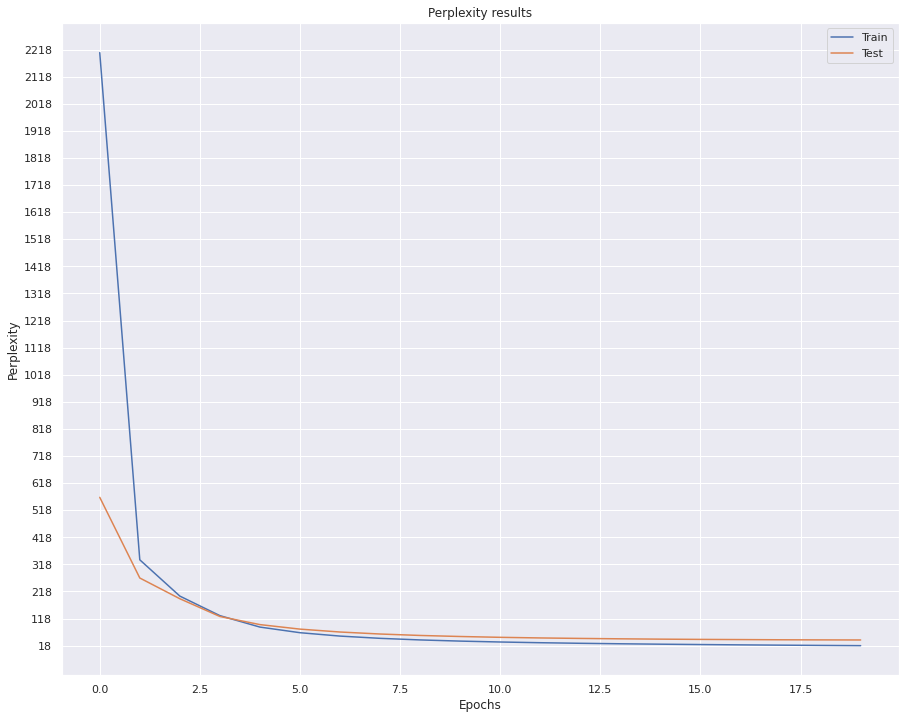

In [187]:
plt.figure(figsize=(15,12))
plt.title('Perplexity results')
plt.plot(df['train_perplexity'])
plt.plot(df['test_perplexity'])
plt.xlabel('Epochs')
plt.ylabel('Perplexity')
plt.yticks(np.arange(min(df['train_perplexity']), max(df['train_perplexity'])+100,100))
plt.legend(['Train', 'Test']);

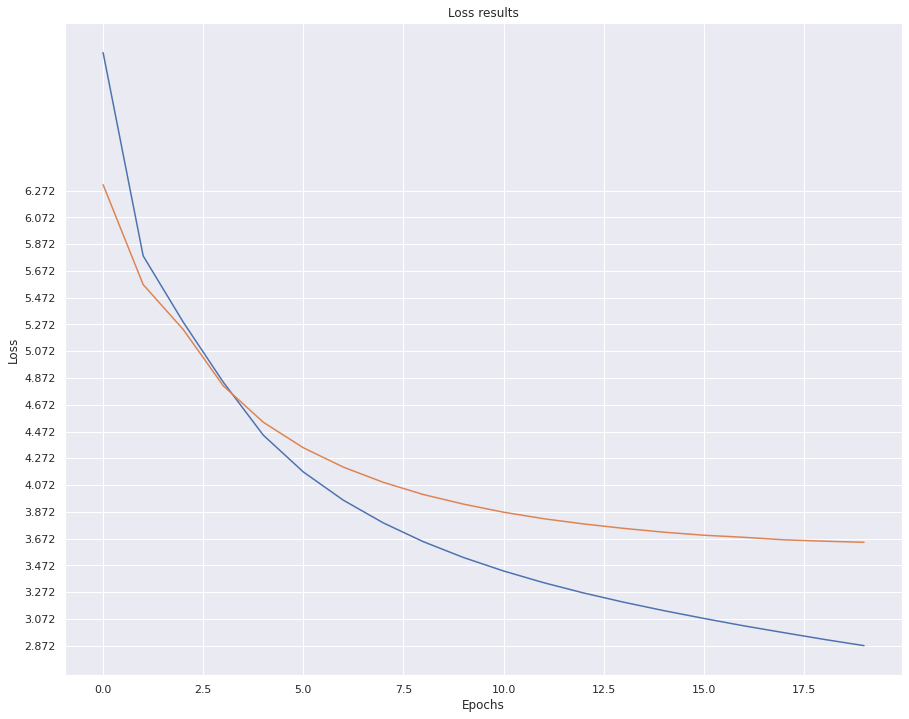

In [188]:
plt.figure(figsize=(15,12))
plt.title('Loss results')
plt.plot(df['train_loss'])
plt.plot(df['test_loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.yticks(np.arange(min(df['train_loss']),max(df['test_loss']),0.2));

# Testing model

In [189]:
import matplotlib.pyplot as plt
import seaborn as sns

In [190]:
class Decoder:
    def __init__(self, encoder: tf.keras.Model,
                 decoder: tf.keras.Model,
                 start_token: int,
                 end_token: int,
                 max_len: int = None):
        self.encoder = encoder
        self.decoder = decoder
        self.max_len = max_len if max_len else 100
        self.start_token = start_token
        self.end_token = end_token

    def decode(self, input):
        pass


class GreedyDecoder(Decoder):
    def __init__(self, encoder: tf.keras.Model,
                 decoder: tf.keras.Model,
                 start_token: int,
                 end_token: int,
                 max_len: int = 10,
                 ):
        super().__init__(encoder,
                         decoder,
                         start_token,
                         end_token,
                         max_len
                         )

    def decode(self, input):
        initial_state = self.encoder(np.expand_dims(input, axis=0))
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = self.start_token
        res = []
        while True:
            # Sample a token
            output, initial_state = self.decoder(target_seq,initial_state)
            sampled_token_index = np.argmax(tf.nn.softmax(output.numpy()))
            if len(res) > self.max_len or sampled_token_index == self.end_token:
                break

            res.append(sampled_token_index)

            target_seq = np.zeros((1, 1))
            target_seq[0, 0] = sampled_token_index

       
        return res


In [191]:
class BeamSearchDecoder(Decoder):
    def __init__(self, encoder: tf.keras.Model,
                 decoder: tf.keras.Model,
                 start_token: int,
                 end_token: int,
                 max_len: int = 10,
                 ):
        super().__init__(encoder,
                         decoder,
                         start_token,
                         end_token,
                         max_len
                         )

    def decode(self, input, beam_size=3):
        start = [self.start_token]
        initial_state = self.encoder(np.expand_dims(input,axis=0))


        start_word = [[start, 0.0, initial_state]]

        while len(start_word[0][0]) < self.max_len:
            temp = []
            for s in start_word:
                target_seq = np.array([[s[0][-1]]])
                initial_state = s[-1]
                output, initial_state= self.decoder(target_seq, initial_state)
                output = np.hstack(output)
                output = tf.nn.softmax(output).numpy()
                word_preds = np.argsort(output)[-beam_size:]

                for w in word_preds:
                    next_cap, prob = s[0][:], s[1]
                    next_cap.append(w)
                    prob += output[w]
                    temp.append([next_cap, prob, initial_state])

            start_word = temp
            # Sorting according to the probabilities
            start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
            # Getting the top words
            start_word = start_word[-beam_size:]

        start_word = start_word[-1][0]

        final_caption = []

        for i in start_word:
            if i != self.end_token:
                final_caption.append(i)
            else:
                break
        return final_caption[1:]

In [192]:
def predict(data, decoder, inverse_vocab,
           beam_size=None):
    if beam_size:
        result = decoder.decode(data, beam_size=beam_size)
    else:
        result = decoder.decode(data)
    return ' '.join([inverse_vocab[i] for i in result])

In [193]:
greedy_decoder = GreedyDecoder(conv_encoder, lstm_decoder, vocab[start_token], vocab[end_token],
             max_len=39)

In [194]:
beam_decoder = BeamSearchDecoder(conv_encoder, lstm_decoder, vocab[start_token], vocab[end_token],
             max_len=39)

In [195]:
images.shape

(3840, 224, 224, 3)

In [248]:
idx = np.random.choice(range(len(images)))
sample = images[idx]

a woman is happy but embarrassed because she in the center of attention of the journalists


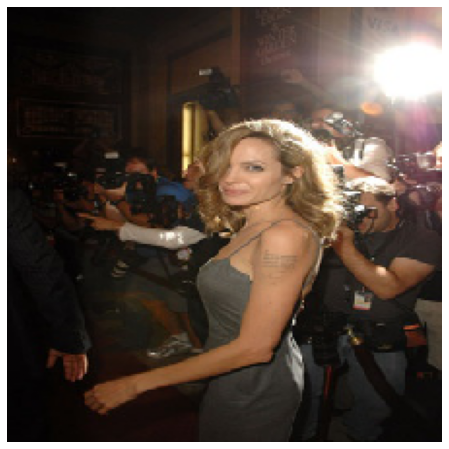

In [249]:
plt.figure(figsize=(8,8))
plt.imshow(sample)
plt.grid([])
plt.axis('off');
print(annotations[idx])

In [250]:
predict(sample, greedy_decoder, inverse_vocab)

'the man is flirting with the woman'

In [251]:
predict(sample, beam_decoder, inverse_vocab, beam_size=5)

'the man is trying to shoot somebody'

# Blue score calculation

In [200]:
from nltk.translate.bleu_score import sentence_bleu


### making predictions on test dataset with beam_size of 5

In [201]:
test_predictions = []
for batch in tqdm(test_images):
    for image in batch:
        result = predict(image, beam_decoder, inverse_vocab, beam_size=5)
        test_predictions.append(result)

100%|██████████| 6/6 [07:32<00:00, 75.50s/it]


In [202]:
test_predictions = [i.split(' ') for i in test_predictions]

In [203]:
reshaped_sequences = test_sequences.reshape(test_sequences.shape[0]*test_sequences.shape[1],-1)

In [204]:
test_sentences = []
for i in reshaped_sequences:
    tmp = []
    for word in i:
        if word!=0 and word!=1 and word!=2:
            tmp.append(inverse_vocab[word])
    test_sentences.append(tmp)

In [205]:
bleu_score = []
for reference, prediction in zip(test_sentences, test_predictions):
    bleu_score.append(sentence_bleu([reference], prediction))
print('Overall bleu score on test data : {}'.format(np.mean(bleu_score)))
df['overall_bleu'] = np.mean(bleu_score)*100

Overall bleu score on test data : 0.014886815985851775


/home/ec2-user/anaconda3/envs/amazonei_tensorflow2_p36/lib/python3.6/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/ec2-user/anaconda3/envs/amazonei_tensorflow2_p36/lib/python3.6/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/ec2-user/anaconda3/envs/amazonei_tensorflow2_p36/lib/python3.6/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
ho

In [206]:
bleu_score = []
for reference, prediction in zip(test_sentences, test_predictions):
    bleu_score.append(sentence_bleu([reference], prediction, weights=(1,)))
print('Bleu score on test data for n-gram = 1 : {}'.format(np.mean(bleu_score)))
df['n1_bleu'] = np.mean(bleu_score)*100

Bleu score on test data for n-gram = 1 : 0.21739314591584083


In [207]:
bleu_score = []
for reference, prediction in zip(test_sentences, test_predictions):
    bleu_score.append(sentence_bleu([reference], prediction, weights=(0,1)))
print('Bleu score on test data for n-gram = 2 : {}'.format(np.mean(bleu_score)))
df['n2_bleu'] = np.mean(bleu_score)*100

Bleu score on test data for n-gram = 2 : 0.08071773641248273


In [208]:
bleu_score = []
for reference, prediction in zip(test_sentences, test_predictions):
    bleu_score.append(sentence_bleu([reference], prediction, weights=(0,0,1)))
print('Bleu score on test data for n-gram = 3 : {}'.format(np.mean(bleu_score)))
df['n3_bleu'] = np.mean(bleu_score)*100

Bleu score on test data for n-gram = 3 : 0.03943375062374194


In [209]:
bleu_score = []
for reference, prediction in zip(test_sentences, test_predictions):
    bleu_score.append(sentence_bleu([reference], prediction, weights=(0,0,0,1)))
print('Bleu score on test data for n-gram = 4 : {}'.format(np.mean(bleu_score)))
df['n4_bleu'] = np.mean(bleu_score)*100

Bleu score on test data for n-gram = 4 : 0.012603345378871526


In [210]:
bleu_score = []
for reference, prediction in zip(test_sentences, test_predictions):
    bleu_score.append(sentence_bleu([reference], prediction, weights=(0.25,0.25,0.25,0.25)))
print('Acuumulated bleu score on test data for n-gram = 4 : {}'.format(np.mean(bleu_score)))
df['acc_bleu'] = np.mean(bleu_score)*100

Acuumulated bleu score on test data for n-gram = 4 : 0.014886815985851775


In [211]:
df.head()

,train_perplexity,test_perplexity,train_loss,test_loss,overall_bleu,n1_bleu,n2_bleu,n3_bleu,n4_bleu,acc_bleu
0,2206.840088,565.400208,7.302434,6.315260,1.488682,21.739315,8.071774,3.943375,1.260335,1.488682
1,334.734985,267.579529,5.783793,5.569399,1.488682,21.739315,8.071774,3.943375,1.260335,1.488682
2,200.797714,191.031479,5.289139,5.233849,1.488682,21.739315,8.071774,3.943375,1.260335,1.488682
3,128.677856,125.535866,4.840572,4.813007,1.488682,21.739315,8.071774,3.943375,1.260335,1.488682
4,86.430573,95.582184,4.444236,4.540800,1.488682,21.739315,8.071774,3.943375,1.260335,1.488682


In [212]:
df.to_csv('{}_logs.csv'.format(model_name),index=False)

In [213]:
conv_encoder.save_weights('{}_encoder.h5'.format(model_name))

In [214]:
lstm_decoder.save_weights('{}_decoder.h5'.format(model_name))